In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/internal-waves/sample_submission.csv
/kaggle/input/internal-waves/train.csv
/kaggle/input/internal-waves/test.csv
/kaggle/input/internal-waves/solution.csv
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/4353.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/2539.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/4803.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/3217.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/3207.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/2673.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/4747.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/3824.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/4358.png
/kaggle/input/internal-waves/images_train-20240709T094004Z-001/im

In [2]:
pwd

'/kaggle/working'

In [3]:
ls /kaggle/input/internal-waves

images_test-20240709T093512Z-001/   sample_submission.csv  test.csv
images_train-20240709T094004Z-001/  solution.csv           train.csv


In [4]:
import os
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [5]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image, ImageReadMode

from torch import nn
from torchvision import transforms

from sklearn.model_selection import train_test_split

## Checkout train and test data and aggregation

In [6]:
traindata_df = pd.read_csv("/kaggle/input/internal-waves/train.csv")
testdata_df = pd.read_csv("/kaggle/input/internal-waves/test.csv")

In [7]:
traindata_df['ground_truth'].value_counts()

ground_truth
1    1724
0    1677
Name: count, dtype: int64

In [8]:
traindata_df["imagepath"] = "/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/" + traindata_df['id'].astype(str) + ".png"
testdata_df["imagepath"] = "/kaggle/input/internal-waves/images_test-20240709T093512Z-001/images_test/" + testdata_df['id'].astype(str) + ".png"

In [9]:
testdata_df.head()

,id,imagepath
0,1,/kaggle/input/internal-waves/images_test-20240...
1,5,/kaggle/input/internal-waves/images_test-20240...
2,7,/kaggle/input/internal-waves/images_test-20240...
3,8,/kaggle/input/internal-waves/images_test-20240...
4,15,/kaggle/input/internal-waves/images_test-20240...


In [10]:
traindata_df[traindata_df['ground_truth']==0].reset_index().loc[0,'imagepath']

'/kaggle/input/internal-waves/images_train-20240709T094004Z-001/images_train/565.png'

sample_image: (528, 539, 4)


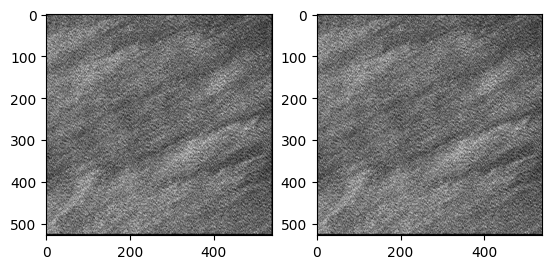

In [11]:
img_idx = np.random.randint(0, high=len(traindata_df[traindata_df['ground_truth']==0]))
sample_path = traindata_df[traindata_df['ground_truth']==0].reset_index().loc[img_idx,'imagepath']
sample_image = plt.imread(sample_path)
print(f"sample_image: {sample_image.shape}")

# using matploblib 
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image);

# read using torchvision.io 
sample_image_ts = read_image(sample_path, mode=ImageReadMode.RGB)
ax[1].imshow(sample_image_ts.permute(1,2,0).numpy());

## CustomImageDataset

In [78]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'imagepath']
        image = read_image(img_path, mode=ImageReadMode.RGB)
        
        label = self.dataframe.loc[idx, 'ground_truth']
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [79]:
# stratify split data
RANDOM_STATE=42
train_idx, valid_idx= train_test_split(np.arange(len(traindata_df)), test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=traindata_df['ground_truth'])

len(train_idx), len(valid_idx)

(2720, 681)

In [14]:
train_split = traindata_df.iloc[train_idx, :].reset_index()
valid_split = traindata_df.iloc[valid_idx, :].reset_index()

traindataset = CustomImageDataset(train_split)
validdataset = CustomImageDataset(valid_split)

train_dataloader = DataLoader(traindataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(validdataset, batch_size=16, shuffle=False)

In [15]:
train_split['ground_truth'].value_counts()

ground_truth
1    1379
0    1341
Name: count, dtype: int64

In [16]:
valid_split['ground_truth'].value_counts()

ground_truth
1    345
0    336
Name: count, dtype: int64

Feature batch shape: torch.Size([16, 3, 528, 539])
Labels batch shape: torch.Size([16])
Label: 1


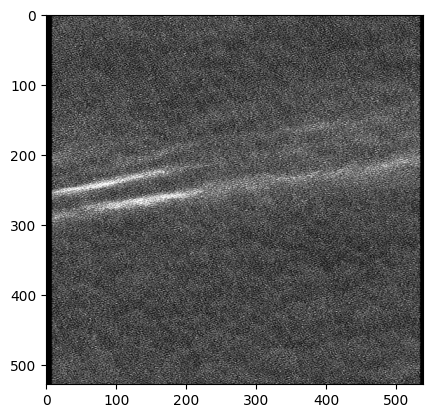

In [17]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img_idx = np.random.randint(0, high=16)
img = train_features[img_idx].squeeze()
label = train_labels[img_idx]

plt.imshow(img.permute(1,2,0))
print(f"Label: {label}")

## Define Model 

In [18]:
classes = {1:"wave", 0:"nowave"}

In [103]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [21]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(classes), seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 139MB/s] 


In [22]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Modulize tranining functions
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py

In [88]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X).squeeze()

        # 2. Calculate  and accumulate loss
#         print(f"y_logits: {y_logits} | y : {y}")
        loss = loss_fn(y_logits, y.to(torch.float))
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
#         y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
#         y_pred_class = torch.argmax(y_pred, dim=1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        train_acc += (y_pred == y).sum().item()/len(y_logits)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X).squeeze()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.to(torch.float))
            test_loss += loss.item()

            # Calculate and accumulate accuracy
#             test_pred_labels = test_pred_logits.argmax(dim=1)
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [104]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [105]:
LEARNING_RATE = 0.001

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=1, seed=42)

# Set loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(),
                             lr=LEARNING_RATE)

In [106]:
traindataset = CustomImageDataset(train_split, transform=effnetb2_transforms)
validdataset = CustomImageDataset(valid_split, transform=effnetb2_transforms)

BATCH_SIZE = 64
train_dataloader = DataLoader(traindataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)


valid_dataloader = DataLoader(validdataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)

In [107]:
EPOCHS=30

train_results = train(model= effnetb2, 
                      train_dataloader=train_dataloader, 
                      test_dataloader=valid_dataloader, 
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=EPOCHS,
                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5997 | train_acc: 0.7093 | test_loss: 0.5464 | test_acc: 0.7984
Epoch: 2 | train_loss: 0.4972 | train_acc: 0.7842 | test_loss: 0.4565 | test_acc: 0.8112
Epoch: 3 | train_loss: 0.4529 | train_acc: 0.8078 | test_loss: 0.4273 | test_acc: 0.8296
Epoch: 4 | train_loss: 0.4306 | train_acc: 0.8154 | test_loss: 0.4106 | test_acc: 0.8353
Epoch: 5 | train_loss: 0.4194 | train_acc: 0.8219 | test_loss: 0.3981 | test_acc: 0.8453
Epoch: 6 | train_loss: 0.4083 | train_acc: 0.8223 | test_loss: 0.3901 | test_acc: 0.8445
Epoch: 7 | train_loss: 0.4031 | train_acc: 0.8365 | test_loss: 0.3797 | test_acc: 0.8445
Epoch: 8 | train_loss: 0.3985 | train_acc: 0.8238 | test_loss: 0.3781 | test_acc: 0.8473
Epoch: 9 | train_loss: 0.3777 | train_acc: 0.8361 | test_loss: 0.3725 | test_acc: 0.8445
Epoch: 10 | train_loss: 0.3867 | train_acc: 0.8321 | test_loss: 0.3651 | test_acc: 0.8558
Epoch: 11 | train_loss: 0.3783 | train_acc: 0.8350 | test_loss: 0.3606 | test_acc: 0.8601
Epoch: 12 | train_l

In [108]:
train_results = pd.DataFrame(train_results)

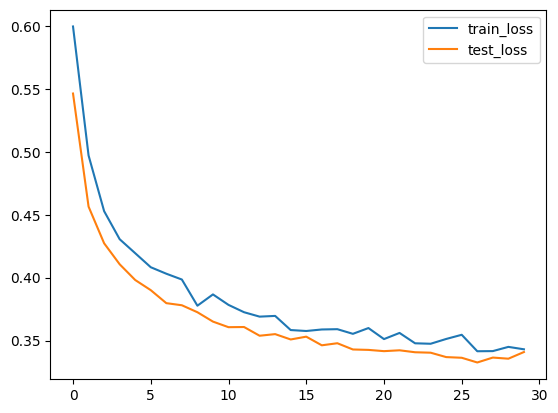

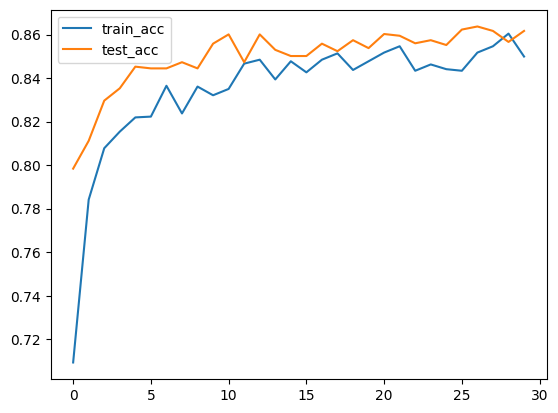

In [109]:
train_results[['train_loss', 'test_loss']].plot();
train_results[['train_acc', 'test_acc']].plot();

In [170]:
# Save the model state_dict()
torch.save(obj=effnetb2.state_dict(),f="wavemodel.pth")

In [172]:
ls -l 

total 30548
-rw-r--r-- 1 root root     9888 Sep 22 17:20 submission.csv
-rw-r--r-- 1 root root     3541 Sep 22 17:25 submission.csv.zip
-rw-r--r-- 1 root root 31263546 Sep 22 17:25 wavemodel.pth


## Run on test data

In [144]:
# image = testdata_df['imagepath'].values.tolist()

image_index=np.random.randint(0, high=len(valid_split))
# image, label = valid_split[['imagepath','ground_truth']].values.tolist()[image_index]

y_preds = []

effnetb2.to(device)
effnetb2.eval()
with torch.inference_mode():
    for image in testdata_df['imagepath'].values.tolist():
        img = read_image(image, mode=ImageReadMode.RGB)
        transformed_image = effnetb2_transforms(img).unsqueeze(dim=0)
        logits = effnetb2(transformed_image.to(device))

        # plt.imshow(img.permute(1,2,0))

        # Convert logits -> prediction probabilities 
        # torch.softmax() for multi-class classification
        # torch.sigmoid() for binary classification
        y_prob = torch.sigmoid(logits.cpu())

        # Convert prediction probabilities -> prediction labels
        y_pred = np.round(y_prob.squeeze().numpy())
        
        y_preds.append(y_pred)

In [145]:
testdata_df['y_preds'] = y_preds
testdata_df["y_preds"] = testdata_df["y_preds"].astype(int)

In [149]:
testdata_df

,id,imagepath,y_preds
0,1,/kaggle/input/internal-waves/images_test-20240...,0
1,5,/kaggle/input/internal-waves/images_test-20240...,1
2,7,/kaggle/input/internal-waves/images_test-20240...,0
3,8,/kaggle/input/internal-waves/images_test-20240...,1
4,15,/kaggle/input/internal-waves/images_test-20240...,1
...,...,...,...
1454,4844,/kaggle/input/internal-waves/images_test-20240...,0
1455,4847,/kaggle/input/internal-waves/images_test-20240...,0
1456,4850,/kaggle/input/internal-waves/images_test-20240...,0
1457,4852,/kaggle/input/internal-waves/images_test-20240...,0


In [152]:
test_true = pd.read_csv("/kaggle/input/internal-waves/solution.csv")

## Model Evaluation

In [161]:
from sklearn.metrics import confusion_matrix, classification_report

In [157]:
test_true['ground_truth'].values

array([1, 1, 1, ..., 0, 0, 0])

In [158]:
y_preds = testdata_df['y_preds'].values
y_trues = test_true['ground_truth'].values

In [159]:
confusion_matrix(y_true=y_trues, y_pred=y_preds)

array([[647,  72],
       [142, 598]])

In [163]:
print(classification_report(y_true=y_trues, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       719
           1       0.89      0.81      0.85       740

    accuracy                           0.85      1459
   macro avg       0.86      0.85      0.85      1459
weighted avg       0.86      0.85      0.85      1459



In [166]:
testdata_df[['id','y_preds']].to_csv("submission.csv", index=False)

In [168]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [173]:
download_file("wavemodel.pth", "wavemodel")

/kaggle/working/wavemodel.zip